# Intermediate notebook 2: stellar rotation rates
Stars rotate. This feature is inherently linked to stellar formation — the molecular clouds from which stars form need only very slightly rotate, and conservation of angular momentum makes sure that the final, formed star rotates, as well.

The rotation rate of a stars tel us about their evolution, their magnetic fields, etc. Stellar light curves (time-series photometry) offer a glimpse into the rotation rates of these bodies. The core idea is that stars are not homogeneous; rather, they can have cooler spots on their surface that rotate in and out of view. The classical picture is of a large single spot that yields a sinusoidal light curve, as an observer detects fewer photons when the spot is in view. In reality, stars are not so ideal — they may have multiple spots at once, and these spots evolve over time. But the general idea remains: the periodicity of a light curve is related to its rotation rate.

In this notebook, we will work through the key mechanics of identifying a star’s rotation period from its TESS light curve. We will then apply this to a large population of stars to understand how rotation rates vary across the M dwarf population.

# Learning objectives
- Extract a stellar rotation rate from a TESS light curve using lightkurve
- Apply the Nyquist-Shannon Samping Theorem when finding stellar rotation rates by restricting periodogram searches
- Assess the level of correlation between two quantities (rotation rate and flare rate)

# Arjun to-do
- check whether flares people do any other processing.
- Julia recent comments
- Make solutions notebook
- Check for binaries
- Motivate the functional form: Montet et al. 2017; Morris 2020, Noyes 1984
- Idea: see if either covary with age?

# Prerequisites
- Familiarity with writing functions: https://www.py4e.com/html3/04-functions
- Previous TIKE notebook: [Classifying stellar flares with stella](../../05-classify-with-ml)

## Import Statements

* **numpy** is used for array manipulation.

* **matplotlib.pyplot** is used to display images and plot datasets.
* **lightkurve** allows us to easily interact with TESS light curves.


In [1]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# file handling and units
import tarfile
from tqdm import tqdm
import astropy
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve

# machine learning and data packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics
import scipy



#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# read from cloud datasets as opposed to downloading from on-premise servers
from astroquery.mast import Observations
Observations.enable_cloud_dataset()


%matplotlib inline

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [2]:
conda run pip install git+https://github.com/afeinstein20/stella

  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-rd7gq2ib
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-rd7gq2ib


Note: you may need to restart the kernel to use updated packages.


In [3]:
import stella

In [57]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

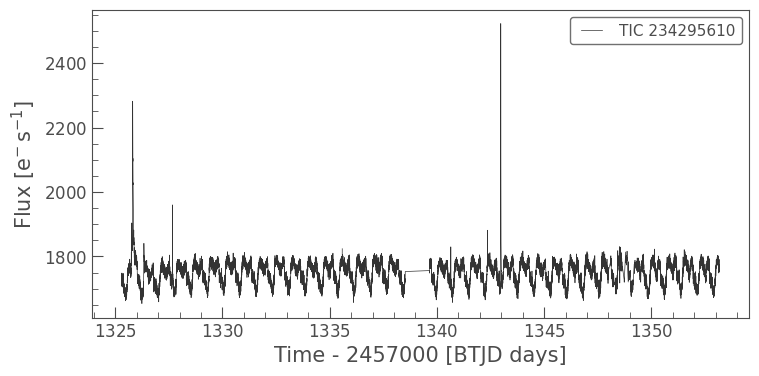

In [58]:
lc.plot()

This light curve is quite interesting. There's definitely at least one source of periodicity (the regularly spaced wiggles in the graph), and there are a few regions of high flux. Might they be flares? We'll return to this question later on by explicitly comparing these features with stellar flare classifiers.

## Exercise 1
Though the peaks in the spectrum may be flares, they may also be "bad data" — some signal that is not related to an astrophysical source. Check the quality flags for any data point above 1900 electrons per second. For reference, see the TIKE notebook on [Quality Flags](../../02-quality-flags).

# Finding periodicity in light curves

To address the first bit—finding periodicity in the data—we need to calculate a *periodogram*. A periodogram is a mathematical estimate of how strong different periods are in a dataset. Under the hood, most periodograms are fundamentally related to <a href="https://news.mit.edu/2009/explained-fourier">Fourier Transforms</a>. 

Before we call the periodogram, we want to consider what a maximum period of the pulsations might be. Based on some science cases, we might be interested in stellar periodicity that is quite long. Betelgeuse, for instance, is a star that <a href="https://arxiv.org/abs/2306.00287">has quite interesting pulsations</a> on the order of 2200 days. However, we're fundamentally limited by our observing strategy based on something called the Nyquist-Shannon Theorem.

## Relevance of the Nyquist-Shannon Sampling Theorem
The <a href="https://chem.libretexts.org/Ancillary_Materials/Laboratory_Experiments/Wet_Lab_Experiments/Analytical_Chemistry_Labs/ASDL_Labware/Analog_and_Digital_Conversion_for_Chemical_Instrumentation/04_Number_Representation/05_The_Nyquist_Sampling_Theorem">Nyquist theorem</a> is a fundamental aspect of signal processing. Essentially, it implies that we cannot search for periodicity that is more than half of an observational baseline. The basic intuition is as follows: for a sine wave, our data would need to at least contain the wave hitting both its peak and its trough for us to understand its period. For more information, see [VanderPlas 2018](https://iopscience.iop.org/article/10.3847/1538-4365/aab766#apjsaab766s3), especially section 3.2.1. 

This idea has direct application to our science goals. TESS observes stars in 28-day baselines (aside from those in the continuous viewing zone); therefore, for most stars that TESS observes, we can only search for periods of at most 14 days when searching a single sector. Let's implement this in code.

In [59]:
(lc.time.max() - lc.time.min()).value

27.88060651831097

In [60]:
lc_interval = (lc.time.max() - lc.time.min()).value

max_period = lc_interval/2

Now that we've set the maximum period, we'll also want to set the minimum_period. Let's set that to the TESS sampling rate: 20 seconds.

In [61]:
min_period = 1 / 24 / 60 / 60 * 20

In [62]:
pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

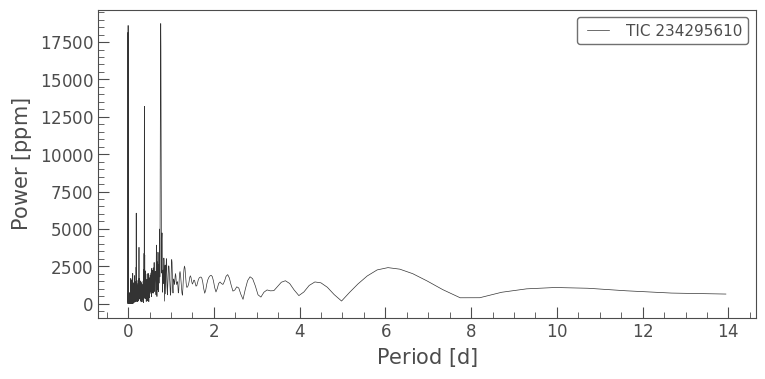

In [63]:
pg.plot();

In [64]:
pg.power

<Quantity [637.4955678 , 703.34846317, 855.36644831, ..., 493.79939553,
           461.89875653, 644.6497039 ] ppm>

We see some strong peaks already in just this single light curve. We haven't even performed any real processing yet!

The "power" quantity on the y-axis indicates how much each particular frequency (or, as plotted on the x-axis, period) contribute to the overall signal.

We can print out the "best" period (the one corresponding to the strongest periodogram peak) with the below command:

In [12]:
pg.period_at_max_power

<Quantity 0.76176521 d>

 Let's plot this periodogram on a log scale. What do we see? (Describe why there's more noise at the low-frequency end of things. Can we assign "proper" bins?)

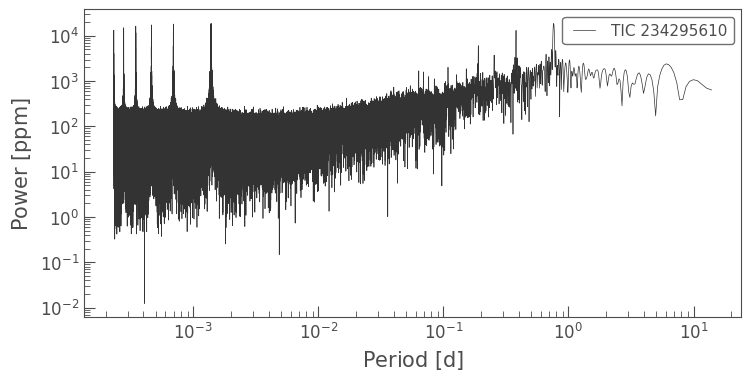

In [13]:
pg.plot(scale='log');

## Exercise 2
Identify the other periods that have relatively high power. Are they harmonics of the 0.762 day period?


# Enforcing a break-up speed limit

It seems like there are some very short-period peaks in the periodogram. Might they be the stellar rotation rate?

Probably not. We expect the rotation rate of of low-mass stars to be on the order of days to tens of days (e.g., <a href="https://adsabs.harvard.edu/full/record/seri/ApJ../0466/1996ApJ...466..384D.html">Donahue et al. 1996</a>). These shorter-period frequencies may be stellar oscillations or pulsations, or harmonic aliases of a single oscillation/pulsation mode. Aliases are multiples of a "true" periodicity that a periodogram can pick out. For instance, if we observe something with a period of 2 days, the periodogram may also note a strong periodic signals at 4 days, 6 days, etc. because the 2 day cycle also coincides with those other cycles.

We can rule these out as stellar rotation rates that would imply that the star is rotating at twice the breakup speed of a main-sequence star. Let's first calculate the break-up rotational period of the Sun. A simplistic approach, ignoring for instance radiation pressure and the changing geometry of a star at higher rotation rates (i.e., bulging at the equator), finds this relationship by setting the equatorial centrifugal acceleration and acceleration by gravity to be equal.

In [14]:
G = const.G
M = 1 * u.M_sun
R = 1 * u.R_sun
vc = (G * M / R)**.5

P = 2 * np.pi * R  / vc

In [15]:
P.to(u.day)

<Quantity 0.11583594 d>

Let's generously assume that a star in our sample could rotate 100 times faster than this without breaking up. In doing so, we're letting M independently vary by a factor of 10,000. Given what we know about mass-radius relationships of stars (todo: cite), this is at least at minimum a plausible physical assumption on the stellar main sequence.

This sets a new minimum period that's longer than our sampling rate. Note that this approach works well enough, but it is not precise enough for publishable research. For a manuscript, other caveats would need to be assessed — e.g., explicitly checking the stellar type of the object we are examining.

In [16]:
min_period = P.to(u.day).value/100

In [17]:
pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


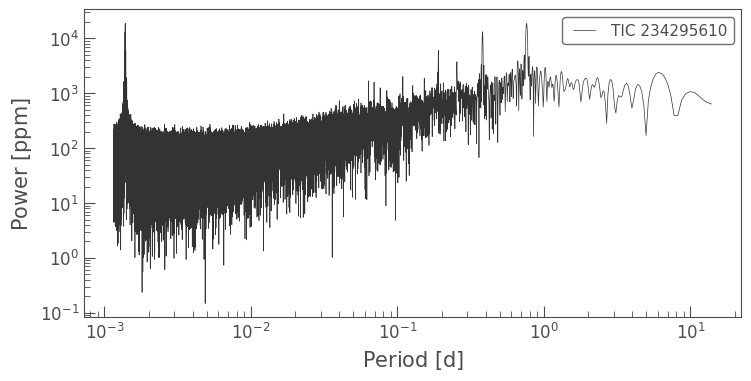

In [18]:
pg.plot(scale='log');

Cool! It looks like our strongest signal is now clearly the peak just shy of 1 day.

## The impact of "data cleaning"

Next, let's consider what might happen to this periodogram if we consider "standard" data-cleaning practices for light curves. For instance, we can perform outlier rejection, removing points from the lightcurve if they stray too far (as specified by a number of datndard deviations) from the mean. `lightkurve` provides a clear method for removing outliers in its lightcurves.

/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

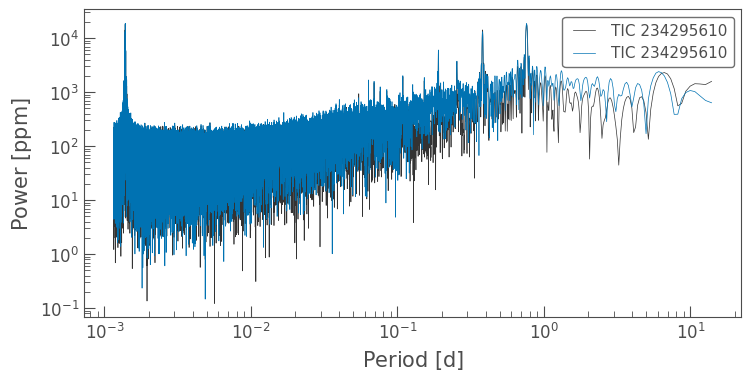

In [19]:
lc_clipped = lc.remove_outliers(sigma=3)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

## Exercise 3
Show that all the periodicity is removed if you are too selective in your sigma clipping, by removing all 1-sigma outliers.
todo: move the below to a solutions notebook!

# Rotation rates of a larger population
Now let's wrap the above in a function so that we can run it on a number of different objects.

In [54]:
max_period

13.940303259155485

In [20]:
def calc_rotation_rate(name):
    """
    Calculates the roation period of a star, assuming that rotation is the primary driver of the star's periodicity. 
    
    Inputs
    ------
        :name: name of star (str)
        
    Outputs
    -------
        :period_at_max_power: the dominant period in the light curve. [float]
    """
    
    
    # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
    
    return pg.period_at_max_power

In [21]:
min_period

0.0011583593643177056

We can gather a population of stars using a flare catalog from a previous notebook ([Classifying stellar flares with stella](../../05-classify-with-ml)).

In [22]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'
file = tarfile.open(download_file(file_url, cache=True))
file.extractall('.')
file.close() # be sure to close files when you're finished with them!


With the file now downloaded, we can use the `astropy` package to simply read in the flare catalog file.

In [23]:
data_dir = './hellouniverse_stella_500/'
filename = 'Guenther_2020_flare_catalog.txt'

catalog = astropy.io.ascii.read(data_dir + filename)  
catalog

TIC,Outbst,Flare,tpeak,e_tpeak,E_tpeak,Amp,e_Amp,E_Amp,FWHMdt,e_FWHMdt,E_FWHMdt,Ebol,e_Ebol,E_Ebol,MCME,e_MCME,E_MCME
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2760232,1,1,2458357.381046,0.000863,0.000854,0.01475,0.00168,0.0017,0.01958,0.00307,0.00375,--,--,--,--,--,--
2760232,2,1,2458357.843604,0.001059,0.001026,0.01389,0.00162,0.00175,0.01612,0.00338,0.00394,--,--,--,--,--,--
2760232,3,1,2458359.79077,2.6e-05,2.6e-05,0.28258,0.00817,0.00949,0.00196,0.00017,0.00017,--,--,--,--,--,--
2760232,3,2,2458359.793415,0.000195,0.000195,0.04634,0.00589,0.00598,0.0061,0.00063,0.00062,--,--,--,--,--,--
2760232,3,3,2458359.816881,0.001735,0.001565,0.01665,0.00185,0.00155,0.05816,0.0092,0.00928,--,--,--,--,--,--
2760232,3,4,2458359.876649,0.000255,0.000404,0.01459,0.00396,0.00433,0.00265,0.00096,0.00233,--,--,--,--,--,--
2760232,5,1,2458360.659582,0.000143,0.00015,0.03723,0.00206,0.00224,0.00456,0.00038,0.00041,--,--,--,--,--,--
2760232,7,1,2458368.775507,6.5e-05,5.5e-05,0.13041,0.01312,0.01632,0.00156,0.00033,0.00033,--,--,--,--,--,--
2760232,7,2,2458368.781088,0.000302,0.000407,0.06287,0.01261,0.00799,0.00837,0.0011,0.00117,--,--,--,--,--,--


We're just interested in the stars themselves, which we can access with the following syntax:

In [24]:
stars = catalog['TIC'].data
stars

array([  2760232,   2760232,   2760232, ..., 471015484, 471015484,
       471015484])

Now, we apply this to the population. The whole population is quite large — if we take every 200th star, then the calculation will only take less than a couple of minutes.

In [52]:
# rot_rates = []

# # iterate though stars
# for star in tqdm(stars[::200]):
#     star_name = str(star) # the rotation rate function takes strings
    
#     rot_rate = calc_rotation_rate(star_name)
    
#     # store result of rotation rate calculation
#     rot_rates += [rot_rate]


rot_rates = []
for star in tqdm(stars[::200]):
    rot_rate = calc_rotation_rate(str(star))
    
    rot_rates += [rot_rate]

  0%|          | 0/44 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  2%|▏         | 1/44 [00:00<00:23,  1.83it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  7%|▋         | 3/44 [00:01<00:23,  1.75it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  9%|▉         | 4/44 [00:02<00:24,  1.63it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 11%|█▏        |

We can use a histogram to get a sense of how the periods are distributed.

(0.0, 14.0)

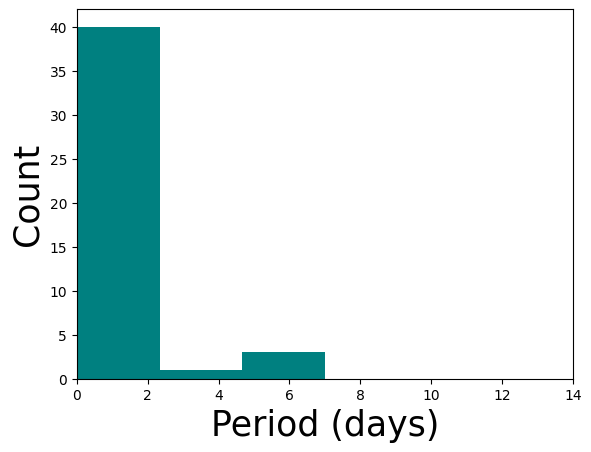

In [53]:
bins=np.linspace(0,14,7)
plt.hist(rot_rates, color='teal',bins=bins)
plt.xlabel('Period (days)', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xlim(0,14)

In the above plot, we see a broad distribution of periodicities. Most of this clusters around 0-1 days, but we see some longer-period objects as well.

# Assessing flares for this population
In a previous notebook, we trained a convolutional neural network (CNN) to classify stellar flares using the `stella` package (<a href="https://joss.theoj.org/papers/10.21105/joss.02347.pdf">Feinstein et al. 2020</a>). Now, we'll use the code and intuition developed in that notebook to answer the following question: Does a star's rotation rate affect its flaring rate?

In [27]:
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+filename) # using the same catalog as above

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 289.13it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [28]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs. TODO: add docstring.'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]


In [29]:
# first, we load the mode.
cnn_file = 'initial_flare_model_small_dataset.h5' #AS: ask about where the files are from previous notebooks!
model = keras.models.load_model(cnn_file)

In [30]:
# set up the ConvNN object.
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

Next, let's check that our classifier is working correctly. To do so, we can just apply it to the first light curve we assessed above.

In [31]:
cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


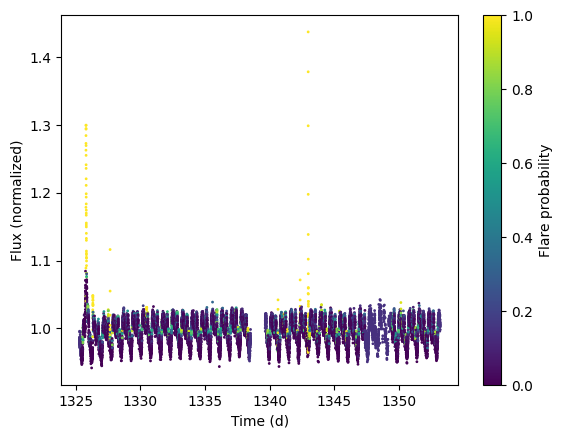

In [32]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.ylabel('Flux (normalized)')
plt.colorbar(im, label='Flare probability')
plt.show()


This seems to make sense. The "peakiest" parts of the light curves are labeled as flares by our classifier at high probability. To further verify this, we can zoom in and pick out some of the flare morphologgy.

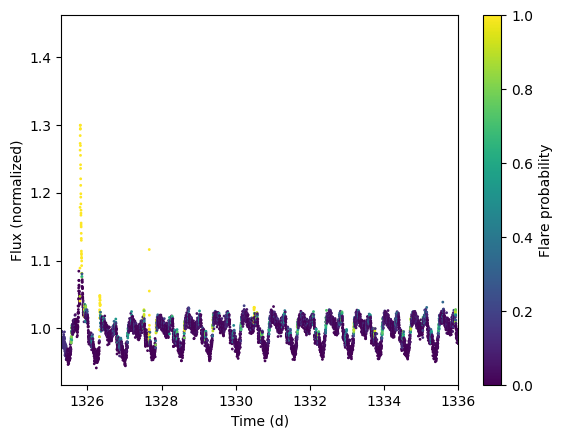

In [33]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.xlim(lc.time.min().value, 1336)
plt.ylabel('Flux (normalized)')
plt.colorbar(im, label='Flare probability')
plt.show()

We see a sharp increase in the flux followed by a slower fall — an example of classic flare morphology (e.g., <a href=https://iopscience.iop.org/article/10.3847/1538-3881/ac6fe6/meta>Mendoza et al. 2022</a>). Looks like the classifier that's working!

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


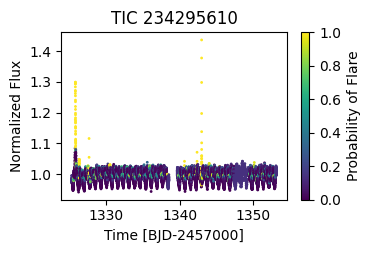

In [34]:
# if len(lc)>0: lc = lc[0]

# predict the flare probability light cuvey for the input data using `stella` 
# (which applies the necessary pre-processing to the data for input to the CNN)
fig = plt.figure(0, [8, 10])
i = 0

cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

ax = fig.add_subplot(4,2,i+1)
im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )

plt.colorbar(im, ax=ax, label='Probability of Flare')
ax.set_xlabel('Time [BJD-2457000]')
ax.set_ylabel('Normalized Flux')
ax.set_title('TIC {}'.format(lc.targetid));

How do we next assess the flare *rate*, now that we've identified flares in our light curve? The simplest thing to do here (and the thing we will start with) is to calculate what fraction of the time is spent flaring. Whlie this may overemphasize the presence of large / long flares, this metric is a good starting point.

In [35]:
flare_cutoff = 0.5 # the minimum value above which the CNN classifies a flare

total_length = len(cnn_stella.predictions[0])
flaring_length = len(cnn_stella.predictions[0][cnn_stella.predictions[0] > flare_cutoff])
frac_flaring = flaring_length/total_length

Text(0, 0.5, 'Period at max power (d)')

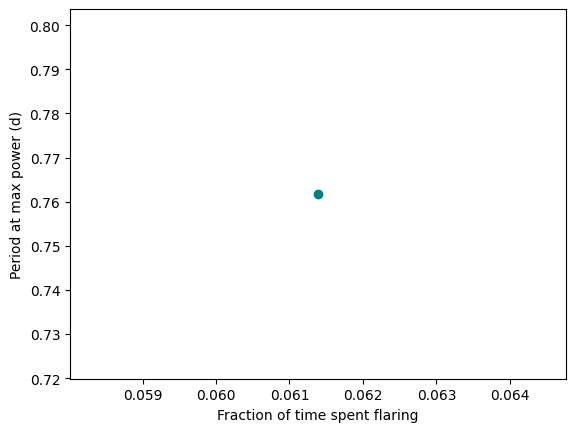

In [36]:
plt.scatter(frac_flaring, pg.period_at_max_power, color='teal')

plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

## Exercise 4
There are more robust ways to determine flare rate. For instance, instead of dividing in-flare time by total flare time, we can assess the number of flares per day. Plot the number of flares per day against the rotation rate — does the functional form of this relationshiup look different from the plot generated in this notebook>

That's a single data point! The next step is to do this for the whole  population.

In [37]:
def calc_flare_rate(name):
    """
    todo: add docstring.
    """
    sectors = [1, 2] # only consider the first few sectors.
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    flare_rate = len(cnn_stella.predictions[0][cnn_stella.predictions[0] > 0.5])/len(cnn_stella.predictions[0])
    
    return flare_rate

Running the below for the whole population shouldn't take more than 3-4 minutes. We won't use the `tqdm` package this time, because it will produce a lot of output in combination with the `stella` predictions.

In [38]:
flare_rates = []
for star in stars[::200]:
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

568/568 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 2s 4ms/step


100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


We first examine our flare rate alone.

Text(0, 0.5, 'Count')

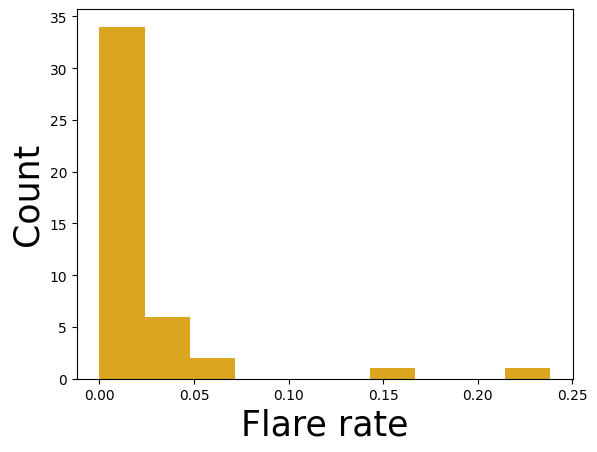

In [39]:
plt.hist(flare_rates, color='goldenrod')
plt.xlabel('Flare rate', fontsize=25)
plt.ylabel('Count', fontsize=25)


# Comparing flare rate and rotation rate
We expect that these two should be related. Even ignoring things like MHD, stars should flare less as they age, and they should spin more slowly with age. [reword this to be better]

In [40]:
rot_rates = [rot_rate.value for rot_rate in rot_rates]

Text(0, 0.5, 'Period at max power (d)')

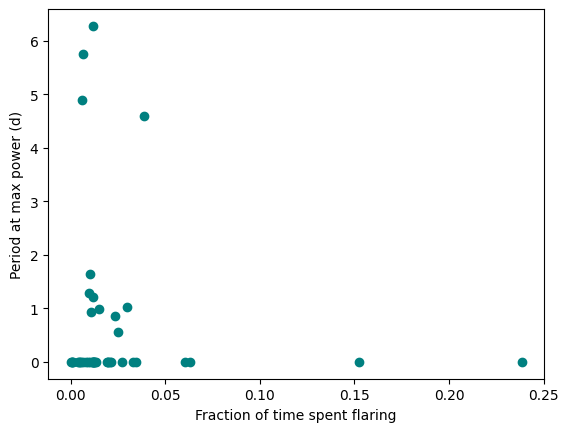

In [41]:
plt.scatter(flare_rates, rot_rates, color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')


Many astrophysical processes obey log-linear scaling relationships. That is, when we plot some relationships on log-log axes, they look like straight lines. Let's see what happens when we plot our data on a log-log plot.

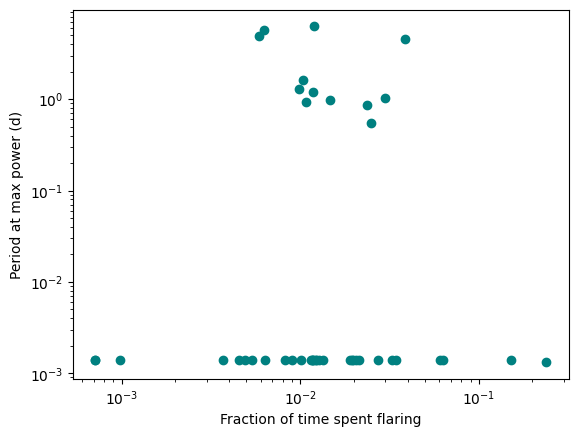

In [42]:
plt.scatter(flare_rates, rot_rates, color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')
plt.yscale('log')
plt.xscale('log')

From this plot, it appears that shorter-period stars spend more time flaring. Let's quantify this statistically.

To do so, let's perform linear regression on our data.

In [43]:
rot_rates, flare_rates = np.array(rot_rates), np.array(flare_rates)

In [44]:
rot_rates_cleaned = rot_rates[flare_rates>0.0]
flare_rates_cleaned = flare_rates[flare_rates>0.0]

In [45]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned))

In [46]:
slope, intercept

(0.09870750841566271, -1.804591291392643)

In [47]:
rot_rates_cleaned

array([1.38409200e-03, 4.59366975e+00, 1.20972607e+00, 1.38805468e-03,
       1.38922475e-03, 1.64003738e+00, 1.31930115e-03, 1.38886811e-03,
       6.27717087e+00, 1.39059780e-03, 1.39054778e-03, 1.39044960e-03,
       1.38702839e-03, 1.38697488e-03, 1.38822757e-03, 1.39087402e-03,
       1.39097577e-03, 1.39302177e-03, 1.38294754e-03, 1.38885631e-03,
       1.39343769e-03, 1.39215632e-03, 1.02390983e+00, 1.38952110e-03,
       5.51004343e-01, 1.38582432e-03, 1.39045573e-03, 1.38767451e-03,
       1.39068669e-03, 1.29075950e+00, 1.39151968e-03, 1.39052134e-03,
       1.38863622e-03, 1.39227218e-03, 1.38761622e-03, 8.57334056e-01,
       1.38961640e-03, 1.38847558e-03, 1.38884853e-03, 9.35585052e-01,
       9.81691215e-01, 5.75033874e+00, 4.88842932e+00])

In [48]:
x = np.linspace(np.min(np.log10(flare_rates_cleaned)), np.max(np.log10(flare_rates_cleaned)), 100)
y = slope * x + intercept

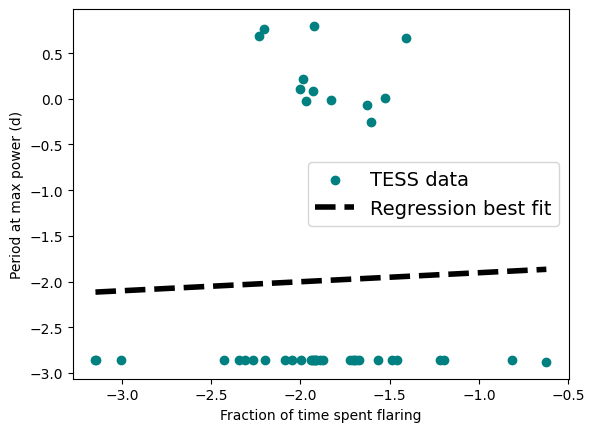

In [49]:
plt.scatter(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')
plt.legend(fontsize=14);
# plt.yscale('log')
# plt.xscale('log')

In [66]:
def calc_rotation_rate_stella(name):
     # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    lc = lc.normalize()
    lc = lc.remove_nans()
    mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux.value], [lc.flux_err.value])
    mProt.run_LS()

    
    return mProt.LS_results['period_days'].value[0]


rot_rates = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate_stella(star_name)
    
    # store result of rotation rate calculation
    rot_rates += [rot_rate]

100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


In [73]:
rot_rates = np.array(rot_rates)

In [74]:
rot_rates_cleaned = rot_rates[flare_rates>0.0]
flare_rates_cleaned = flare_rates[flare_rates>0.0]

In [78]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned))

x = np.linspace(np.min(np.log10(flare_rates_cleaned)), np.max(np.log10(flare_rates_cleaned)), 100)
y = slope * x + intercept

/tmp/ipykernel_1803/2042238044.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal', label='TESS data')


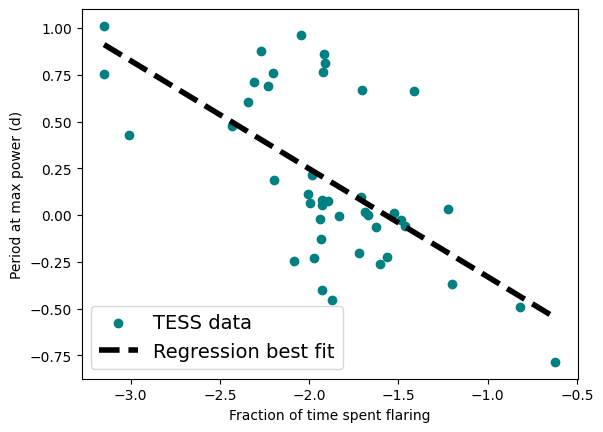

In [83]:
plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')
plt.legend(fontsize=14);
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
# todo: why is the previous approach for rotation-finding failing now?

# Additional exercises
5. In Feinstein et al. 2020, the authors describe three criteria that define robust rotation rates. Implement the below, being sure to mask out harmonics before identifying the secondary peak. Do these steps change your answers? HINT: the `stella` package may include some useful functionality.
    - <i>the rotation rate must be less than 12 days</i>
    - <i>the width of a Gaussian fit to the peak power must be less than 40% of the peak period</i>
    - <i>the secondary peak in the power spectrum must be 4% weaker than the primary peak</i>
6. Feinstein et al. 2020 also identified the below checks for verifying flares. Implement these, as well; does this impact the flares vs. rotation rate plot?
    - <i>the amplitude of the flare must be 1.5σ > the locally detrended light curve</i>
    - <i>the two cadences directly following the amplitude must be 1σ > the detrended light curve (i.e., at least three consecutive outlier points are considered part of a flare);</i>
    - <i>the cadence before and after the flare amplitude must be less than the amplitude;</i>
    - <i>the amplitude must be >0.5%.</i>  
7. Find the statistical significance of the relationship we found.
    

# Resources
- <a href=https://github.com/afeinstein20/stella> stella GitHub repository </a>
- <a href=https://adina.feinste.in/stella/> stella documentation </a>
- <a href=https://adsabs.harvard.edu/full/2004IAUS..215...57G>review on stellar rotation in clusters</a>
- <a href=https://iopscience.iop.org/article/10.3847/1538-4365/aab766/meta>VanderPlas 2018: Understanding the Lomb–Scargle Periodogram</a>
- <a href=https://online.stat.psu.edu/stat510/lesson/6/6.1#:~:texta%20time%20series.-,Periodogram,encountered%20monthly%20or%20quarterly%20seasonality.>Introduction to periodograms</a>
<a href=https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem>Wikipedia article on the Nyquist-Shannon sampling theorem</a>

In [50]:
import multiprocessing

In [51]:
multiprocessing.cpu_count()

4

In [ ]:
# todo: why are my rotation rates so low now?